In [1]:
import sys
import os
import pandas as pd
import numpy as np
import pickle

In [2]:
# Add src to path
sys.path.append(os.path.abspath(os.path.join('..')))
from src.model_utils import evaluate_model, run_cross_validation

In [3]:
# --- SUPER PATCH for Scikit-Learn 1.6+ Compatibility ---
# We need this in every notebook that uses SMOTE until libraries update
import sklearn.utils.validation
import sklearn.ensemble

# Patch 1: Fix missing _is_pandas_df function
if not hasattr(sklearn.utils.validation, '_is_pandas_df'):
    sklearn.utils.validation._is_pandas_df = lambda x: hasattr(x, 'dtypes') and hasattr(x, 'columns')

# Patch 2: Fix AdaBoost algorithm parameter removal
OriginalAdaBoost = sklearn.ensemble.AdaBoostClassifier
class PatchedAdaBoost(OriginalAdaBoost):
    def __init__(self, *args, **kwargs):
        kwargs.pop('algorithm', None)
        super().__init__(*args, **kwargs)
sklearn.ensemble.AdaBoostClassifier = PatchedAdaBoost
# --- END PATCH ---

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline # Pipeline that handles SMOTE correctly

In [4]:
# Load Data
merged_df = pd.read_csv('../data/processed/Fraud_Data_Merged.csv')
print("Data Loaded:", merged_df.shape)

Data Loaded: (129146, 18)


In [5]:
# 1. Feature Engineering (Re-creating the missing column)
# Calculate how many times a device has been used
device_freq = merged_df['device_id'].value_counts()
merged_df['device_transaction_count'] = merged_df['device_id'].map(device_freq)

# 2. Define X and y
# Drop ID columns and existing target
X = merged_df.drop(['class', 'user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address'], axis=1)
y = merged_df['class']

# 3. Define Features
numeric_features = ['purchase_value', 'age', 'ip_address_int', 'time_since_signup', 'hour_of_day', 'day_of_week', 'device_transaction_count']
categorical_features = ['source', 'browser', 'sex', 'country']

# 4. Create Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 5. Split Data (Stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (103316, 13)
Test shape: (25830, 13)


Training Baseline Logistic Regression...
--- Logistic Regression Evaluation ---
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     23376
           1       0.67      0.64      0.65      2454

    accuracy                           0.94     25830
   macro avg       0.81      0.80      0.81     25830
weighted avg       0.93      0.94      0.93     25830

AUC-ROC: 0.8379
AUC-PR:  0.6687


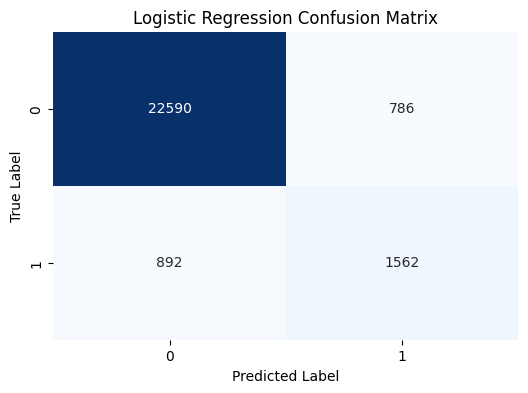

In [6]:
# Define the Pipeline: Preprocessor -> SMOTE -> Model
pipeline_lr = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Train
print("Training Baseline Logistic Regression...")
pipeline_lr.fit(X_train, y_train)

# Evaluate
metrics_lr = evaluate_model(pipeline_lr, X_test, y_test, model_name="Logistic Regression")

Training Random Forest...
--- Random Forest Evaluation ---
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     23376
           1       0.57      0.70      0.63      2454

    accuracy                           0.92     25830
   macro avg       0.77      0.82      0.79     25830
weighted avg       0.93      0.92      0.92     25830

AUC-ROC: 0.8381
AUC-PR:  0.7173


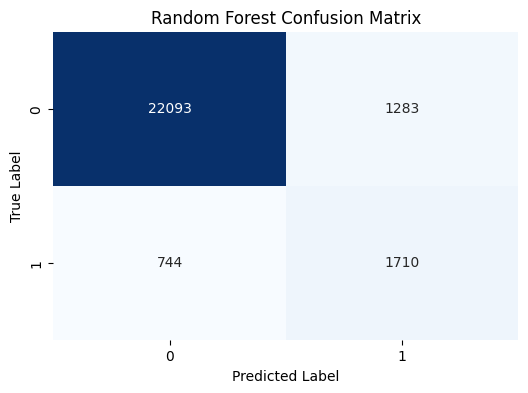

In [7]:
# Random Forest Pipeline
pipeline_rf = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1))
])

# Train
print("Training Random Forest...")
pipeline_rf.fit(X_train, y_train)

# Evaluate
metrics_rf = evaluate_model(pipeline_rf, X_test, y_test, model_name="Random Forest")

Training XGBoost...
--- XGBoost Evaluation ---
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     23376
           1       0.99      0.55      0.71      2454

    accuracy                           0.96     25830
   macro avg       0.97      0.77      0.84     25830
weighted avg       0.96      0.96      0.95     25830

AUC-ROC: 0.8361
AUC-PR:  0.7191


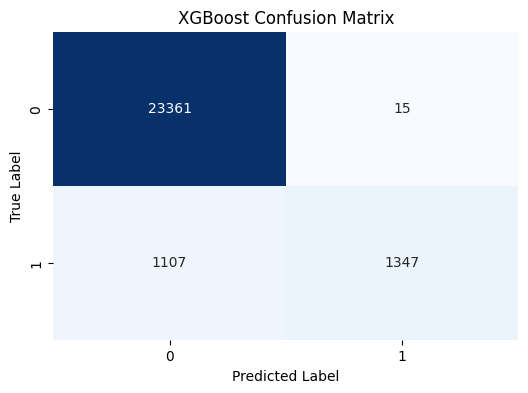

In [8]:
from xgboost import XGBClassifier

pipeline_xgb = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(eval_metric='logloss', random_state=42))
])

print("Training XGBoost...")
pipeline_xgb.fit(X_train, y_train)

metrics_xgb = evaluate_model(pipeline_xgb, X_test, y_test, model_name="XGBoost")

In [9]:
# --- Cross-Validation (Task 2b Requirement) ---
print("--- Performing Stratified K-Fold Cross-Validation (k=5) ---")

# We run CV on the best model (e.g., Random Forest or XGBoost) to confirm its stability
# Note: We use the pipeline, which handles SMOTE inside each fold correctly!

cv_score_rf_mean, cv_score_rf_std = run_cross_validation(pipeline_rf, X_train, y_train, k=5)
print(f"Random Forest CV AUC-PR: {cv_score_rf_mean:.4f} (±{cv_score_rf_std:.4f})")

# Optional: Run on XGBoost too
if 'pipeline_xgb' in locals():
    cv_score_xgb_mean, cv_score_xgb_std = run_cross_validation(pipeline_xgb, X_train, y_train, k=5)
    print(f"XGBoost CV AUC-PR:       {cv_score_xgb_mean:.4f} (±{cv_score_xgb_std:.4f})")

--- Performing Stratified K-Fold Cross-Validation (k=5) ---
Cross-Validation AUC-PR (k=5): 0.7068 +/- 0.0032
Random Forest CV AUC-PR: 0.7068 (±0.0032)
Cross-Validation AUC-PR (k=5): 0.7103 +/- 0.0038
XGBoost CV AUC-PR:       0.7103 (±0.0038)


In [10]:
results_df = pd.DataFrame([metrics_lr, metrics_rf, metrics_xgb])
print(results_df)

# Save the best model (Assuming Random Forest or XGBoost is best)
import joblib

# Create models directory if not exists
os.makedirs('../models', exist_ok=True)

# Save Random Forest (Example)
joblib.dump(pipeline_rf, '../models/fraud_detection_rf_model.pkl')
print("Best model saved to ../models/")

                 Model   AUC-ROC    AUC-PR
0  Logistic Regression  0.837917  0.668654
1        Random Forest  0.838138  0.717343
2              XGBoost  0.836061  0.719123
Best model saved to ../models/
